In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.applications import VGG16
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical, img_to_array, array_to_img
from sklearn.metrics import classification_report

Завантажимо датасет __fashion_mnist__, розділимо його на навчальний та тренувальний, нормалізуємо дані та підготуємо їх для роботи з моделю __VGG16__:

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape([-1, 784])
x_train=np.dstack([x_train]*3)
x_train = x_train.reshape(-1, 28, 28, 3)
x_train=np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_train])
x_train = x_train.astype('float32') / 255.
print('x_train shape:', x_train.shape)

x_test = x_test.reshape([-1, 784])
x_test=np.dstack([x_test]*3)
x_test = x_test.reshape(-1, 28, 28, 3)
x_test=np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_test])
x_test = x_test.astype('float32') / 255.
print('x_test shape:', x_test.shape)

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

x_train shape: (60000, 48, 48, 3)
x_test shape: (10000, 48, 48, 3)


Створимо базову модель __VGG16__ без повнозв’язних шарів та заморозимо її для навчання. Додамо повнозв’язні шари для класифікації:

In [4]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

58889256/58889256 [==============================] - 4s 0us/step


Проведемо навчання та оцінку роботи нашої моделі:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14,848,586
Trainable params: 133,898
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/20
375/375 [==================

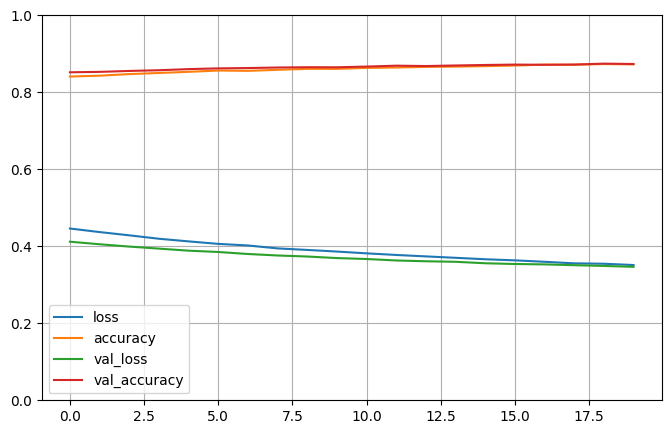

1875/1875 [==============================] - 24s 13ms/step - loss: 0.3232 - accuracy: 0.8827
Train accuracy: 0.8827
313/313 [==============================] - 4s 13ms/step - loss: 0.3639 - accuracy: 0.8703
Test accuracy: 0.8703
313/313 [==============================] - 4s 11ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.83      0.83      1000
     Trouser       0.98      0.97      0.97      1000
    Pullover       0.83      0.78      0.80      1000
       Dress       0.86      0.84      0.85      1000
        Coat       0.73      0.83      0.78      1000
      Sandal       0.96      0.94      0.95      1000
       Shirt       0.68      0.64      0.66      1000
     Sneaker       0.92      0.95      0.94      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.96      0.95      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg

In [7]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.2)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

train_loss, train_accuracy = model.evaluate(x_train, y_train)
print(f"Train accuracy: {train_accuracy:.4f}")
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print(report)

Подивимось на структуру нашої базової моделі __VGG16__:

In [6]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

Розморозимо останні чотири шари нашої базової моделі __VGG16__, проведемо донавчання та оцінку роботи:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14,848,586
Trainable params: 7,213,322
Non-trainable params: 7,635,264
_________________________________________________________________
Epoch 1/20
375/375 [=================

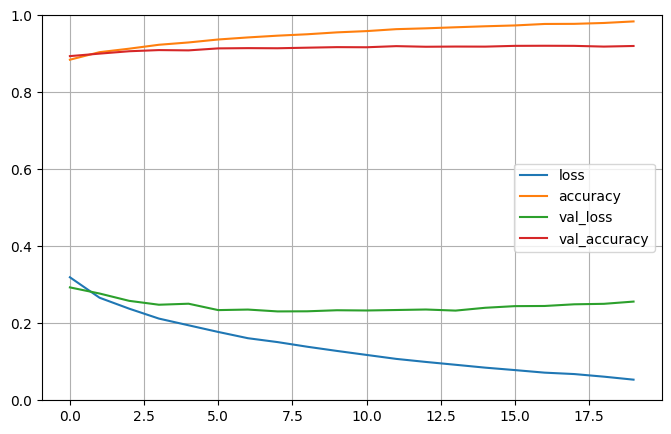

1875/1875 [==============================] - 24s 13ms/step - loss: 0.0818 - accuracy: 0.9765
Train accuracy: 0.9765
313/313 [==============================] - 4s 13ms/step - loss: 0.2839 - accuracy: 0.9169
Test accuracy: 0.9169
313/313 [==============================] - 4s 11ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.89      0.85      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.84      0.91      0.87      1000
       Dress       0.89      0.92      0.91      1000
        Coat       0.93      0.80      0.86      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.74      0.79      0.77      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.98      0.99      0.98      1000
  Ankle boot       0.98      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg

In [8]:
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.2)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

train_loss, train_accuracy = model.evaluate(x_train, y_train)
print(f"Train accuracy: {train_accuracy:.4f}")
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print(report)

В цій частині домашнього завдання ми створили згорткову нейромережу, що використовує модель __VGG16__ в якості згорткової основи. Під час навчання ми використовували прийоми донавчання та виділення ознак. В результаті точність нашої нейромережі виявилась приблизно на рівні згорткової моделі з першої частини завдання. Відсутність збільшення точності можливо можна пояснити тим, що датасети __ImageNet__ на якому була навчена __VGG16__ та використаний в цьому завданні __fashion_mnist__ __не__ є досить схожими.